# Notebook for reproducing Fig 6a and Fig S9

In [1]:
from pathlib import Path

import ase
import matplotlib.pyplot as plt
import numpy as np

# Square system
import tqdm
from ase.atoms import Atoms
from ase.data import atomic_names, atomic_numbers, covalent_radii
from ase.geometry.dimensionality import isolate_components
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import box
from tqdm.auto import tqdm

from mbhl import *

In [2]:
%mkdir -p subfigs-Fig6a

Below are the angle depositions for square and hexagonal lattice nanoapertures

In [38]:
def plot_two_angle_deposition_square(
    ax=None,
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    L=500 * nm,
    H=5 * um,
    diffusion=15 * nm,
    default_h=5 * nm,
    default_alpha=1.0,
    drift=0 * nm,
    gap=2.5 * um,
    cmap="viridis",
    alpha=1.0,
    h_ratio=1.0,
    n_pts=2,
    angle_offset=30,
):
    # We always show 8 x 8 superlattice
    radius = L * rl_ratio
    R = L * Rl_ratio
    phi = np.arctan(R / H / 2)
    angle_offset = theta
    trajectory = n_beam_trajectory(phi, theta_0=theta, n_pts=n_pts)
    phys = Physics(trajectory, diffusion=diffusion, drift=drift)
    W = L
    stencil = Stencil(
        square_hole_lattice(radius, L),
        thickness=0,
        gap=H,
        h=default_h / h_ratio,
    )
    system = System(stencil=stencil, physics=phys)
    system.simulate(method="fft", fold_to_bz=False)
    if ax:
        ax.set_axis_off()
        system.draw(
            ax,
            domain=(W, 9 * W, W, 9 * W),
            mask_alpha=1.0,
            show_mask=False,
            cmap=cmap,
            mask_lw=0,
            alpha=alpha,
        )
    return system

In [28]:
def plot_two_angle_deposition_hex(
    ax=None,
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    L=500 * nm,
    H=5 * um,
    diffusion=15 * nm,
    default_h=5 * nm,
    default_alpha=1.0,
    drift=0 * nm,
    gap=2.5 * um,
    cmap="viridis",
    alpha=1.0,
    h_ratio=1.0,
    n_pts=2,
    angle_offset=30,
):
    # We always show 8 x 8 superlattice
    radius = L * rl_ratio
    R = L * Rl_ratio
    phi = np.arctan(R / H / 2)
    angle_offset = theta
    trajectory = n_beam_trajectory(phi, theta_0=theta, n_pts=n_pts)
    phys = Physics(trajectory, diffusion=diffusion, drift=drift)
    W = L
    stencil = Stencil(
        hexagonal_hole_lattice(radius, L, orientation="horizontal"),
        thickness=0,
        gap=H,
        h=default_h / h_ratio,
    )
    system = System(stencil=stencil, physics=phys)
    conv = system.simulate(method="fft", fold_to_bz=False)
    if ax:
        ax.set_axis_off()
        system.draw(
            ax,
            domain=(W, 9 * W, W, 9 * W),
            mask_alpha=1.0,
            show_mask=False,
            cmap=cmap,
            mask_lw=0,
            alpha=alpha,
        )
    return system

## Example of n=2 on hexagonal lattice 

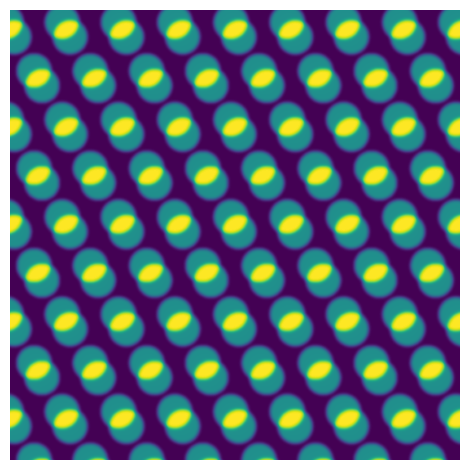

In [29]:
# 0D-hex
system = plot_two_angle_deposition_hex(
    plt.gca(),
    rl_ratio=0.3,
    Rl_ratio=0.3,
    theta=22.5,
    default_h=5 * nm,
    n_pts=2,
)
plt.tight_layout()
plt.savefig("subfigs-Fig6a/2pts-hex-0.3-0.3.png")

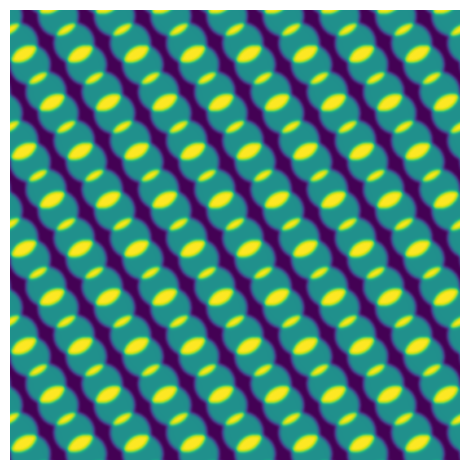

In [30]:
# 1d-hex
system = plot_two_angle_deposition_hex(
    plt.gca(),
    rl_ratio=0.35,
    Rl_ratio=0.55,
    theta=22.5,
    default_h=5 * nm,
    n_pts=2,
)
plt.tight_layout()
plt.savefig("subfigs-Fig6a/2pts-hex-0.35-0.55.png")

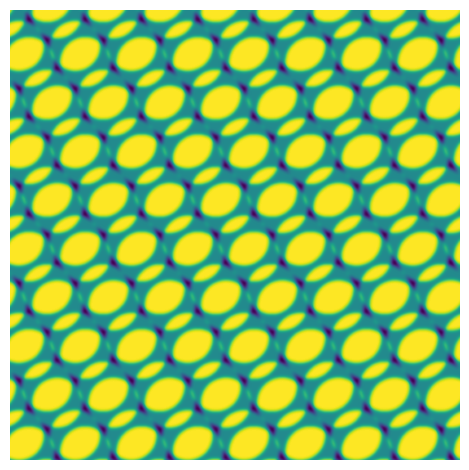

In [34]:
# 2d-hex
system = plot_two_angle_deposition_hex(
    plt.gca(),
    rl_ratio=0.45,
    Rl_ratio=0.65,
    theta=22.5,
    default_h=5 * nm,
    n_pts=2,
)
plt.tight_layout()
plt.savefig("subfigs-Fig6a/2pts-hex-0.45-0.65.png")

## Below are examples of n=2 on square lattice

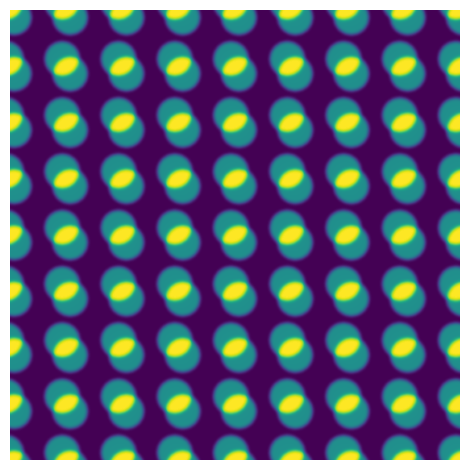

In [39]:
#### 0d on square
plot_two_angle_deposition_square(
    plt.gca(),
    rl_ratio=0.3,
    Rl_ratio=0.3,
    theta=22.5,
    default_h=5 * nm,
)
plt.tight_layout()
plt.savefig("subfigs-Fig6a/2pts-0.3-0.3.png")

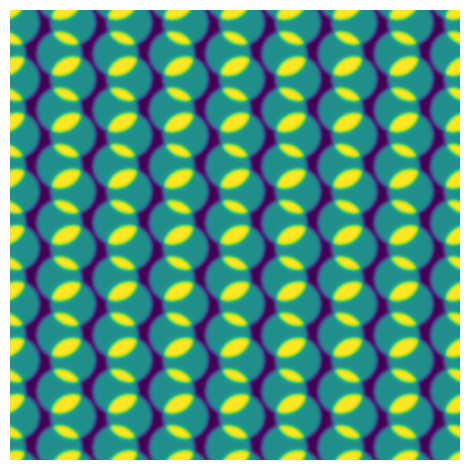

In [42]:
# 1d on square
plot_two_angle_deposition_square(
    plt.gca(),
    rl_ratio=0.40,
    Rl_ratio=0.5,
    theta=22.5,
    default_h=5 * nm,
)
plt.tight_layout()
plt.savefig("subfigs-Fig6a/2pts-0.4-0.5.png")

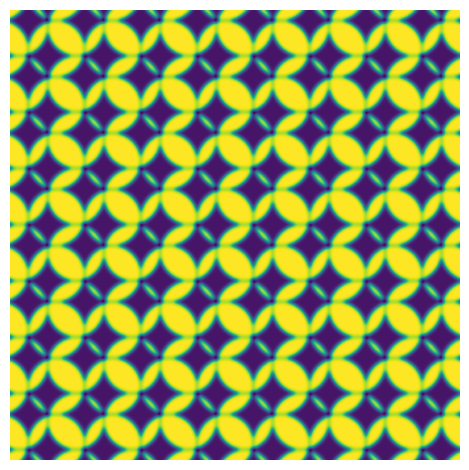

In [43]:
# 2d on square
plot_two_angle_deposition_square(
    plt.gca(),
    rl_ratio=0.50,
    Rl_ratio=0.70,
    theta=22.5,
    default_h=5 * nm,
)
plt.tight_layout()
plt.savefig("subfigs-Fig6a/2pts-0.5-0.7.png")

## Use dimensionality algorithm for atomistic structures to determine phase diagram


In [45]:
def generate_fake_atoms(
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    symbol="X",
    default_r=covalent_radii[0],
    lattice="square",
):
    pbc = [True, True, False]
    L = default_r / rl_ratio
    R = L * Rl_ratio
    if lattice == "square":
        cell = [L, L, 0]
        theta = 90 - theta
        px, py = R * np.cos(np.deg2rad(theta)), R * np.sin(np.deg2rad(theta))
        positions = [[0, 0, 0], [px, py, 0]]
        atoms = Atoms("X2", positions=positions, cell=cell, pbc=pbc)
    elif lattice == "hex":
        cell = [L, L * 3**0.5, 0]
        theta = 90 - theta
        px, py = R * np.cos(np.deg2rad(theta)), R * np.sin(np.deg2rad(theta))
        positions = [
            [0, 0, 0],
            [L / 2, L / 2 * 3**0.5, 0],
            [px, py, 0],
            [L / 2 + px, L / 2 * 3**0.5 + py, 0],
        ]
        atoms = Atoms("X4", positions=positions, cell=cell, pbc=pbc)
    else:
        raise NotImplementedError()
    return atoms

In [46]:
def pattern_dimensionality(
    rl_ratio=0.25, Rl_ratio=0.5, theta=0.0, lattice="square"
):
    atoms = generate_fake_atoms(rl_ratio, Rl_ratio, theta, lattice=lattice)
    comp = isolate_components(atoms, kcutoff=1.05)
    return int(list(comp.keys())[0][0])

First we plot the square lattice using a finer mesh (200 in each direction)

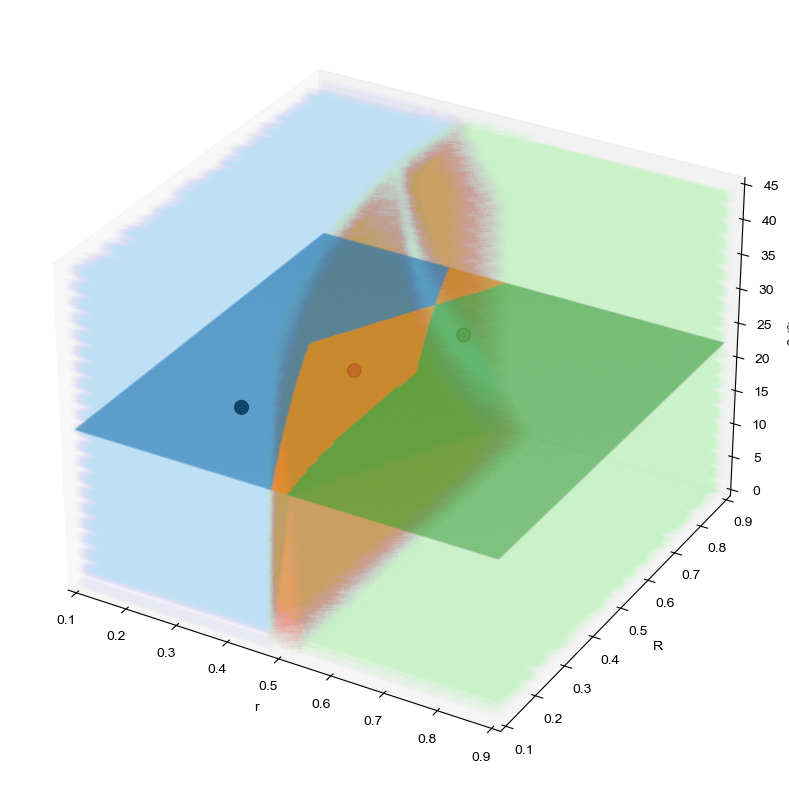

In [47]:
rl_range = np.linspace(0.10, 0.90, 200)
Rl_range = np.linspace(0.10, 0.90, 200)
theta_range = np.linspace(0, 45, 200)
rr, RR, tt = np.meshgrid(rl_range, Rl_range, theta_range)
data_file = Path("subfigs-Fig6a") / "dimensionality-200-square.npy"
if not data_file.exists():
    dm = []
    for r_, R_, t_ in tqdm(
        zip(rr.flatten(), RR.flatten(), tt.flatten()), total=rr.flatten().size
    ):
        dm.append(pattern_dimensionality(r_, R_, t_))
    dm = np.array(dm)
    np.save(data_file, dm)
else:
    dm = np.load(data_file)
ddmm = np.reshape(dm, rr.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
colors = ["w", "r", "gray"]
colors = ["#bfdff5", "#e39f64", "#c9f2c9"]

rr_0d = rr[ddmm == 0]
RR_0d = RR[ddmm == 0]
tt_0d = tt[ddmm == 0]
dm_0d = dm[dm == 0]

rr_1d = rr[ddmm == 1]
RR_1d = RR[ddmm == 1]
tt_1d = tt[ddmm == 1]
dm_1d = dm[dm == 1]

rr_2d = rr[ddmm == 2]
RR_2d = RR[ddmm == 2]
tt_2d = tt[ddmm == 2]
dm_2d = dm[dm == 2]

points_1d = np.column_stack((rr_1d, RR_1d, tt_1d))

# Half of z-max
index = 99
z_height = tt[0, 0, index]
zz = np.ones(rr[:, :, index].shape) * z_height
fc = plt.cm.tab10(ddmm[:, :, index])
# transparent face color, explicit
fc[:, :, -1] = 0.2
ax.plot_surface(
    rr[:, :, index],
    RR[:, :, index],
    zz,
    rstride=1,
    cstride=1,
    facecolors=fc,
    shade=False,
)

scatter = ax.scatter(
    rr_1d[::10],
    RR_1d[::10],
    tt_1d[::10],
    s=45,
    color=colors[1],
    alpha=0.008,
    marker="s",
)
scatter = ax.scatter(
    rr_0d[::10],
    RR_0d[::10],
    tt_0d[::10],
    s=45,
    color=colors[0],
    alpha=0.002,
    marker="s",
)
scatter = ax.scatter(
    rr_2d[::10],
    RR_2d[::10],
    tt_2d[::10],
    s=45,
    color=colors[2],
    alpha=0.002,
    marker="s",
)

dots = np.array(
    [(0.3, 0.3, z_height), (0.4, 0.5, z_height), (0.5, 0.7, z_height)]
)

ax.scatter(dots[:, 0], dots[:, 1], dots[:, 2], s=100, color="k", marker="o")

ax.set_xlim(0.1, 0.9)
ax.set_ylim(0.1, 0.9)
ax.set_zlim(0, 45)

ax.set_xlabel("r")
ax.set_ylabel("R")
ax.set_zlabel("θ (°)")
ax.grid(False)
fig.tight_layout()
fig.savefig("subfigs-Fig6a/3d_phase_diagram_square.png")

A similar phase diagram for hexagonal lattice is plot using slightly coarser mesh (100 in each direction)

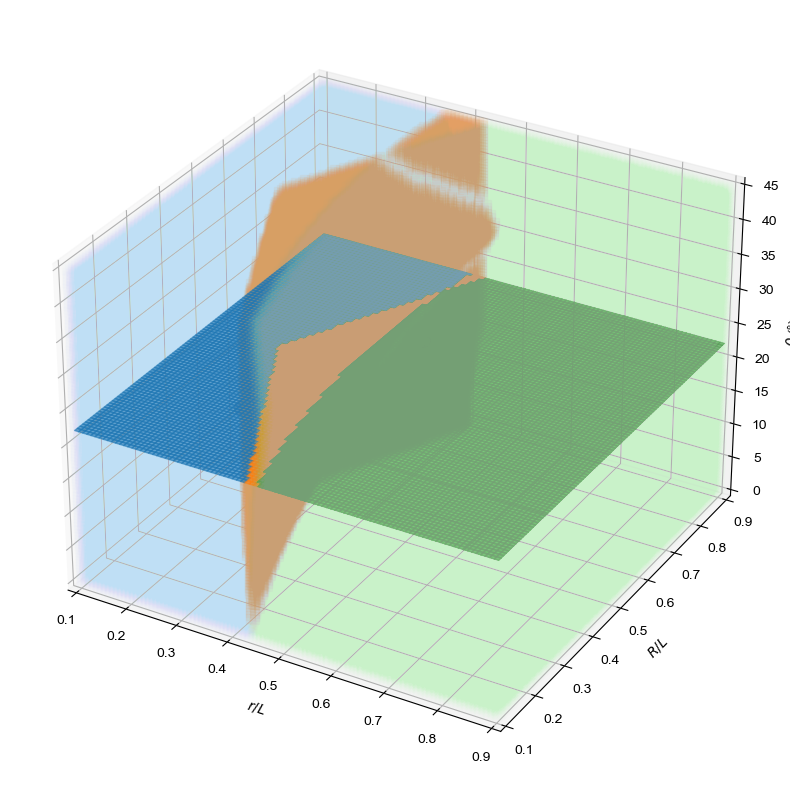

In [48]:
rl_range = np.linspace(0.10, 0.90, 100)
Rl_range = np.linspace(0.10, 0.90, 100)
theta_range = np.linspace(0, 45, 100)
rr, RR, tt = np.meshgrid(rl_range, Rl_range, theta_range)
dm = []
data_file = Path("subfigs-Fig6a") / "dimensionality-100-hex.npy"
if not data_file.exists():
    for r_, R_, t_ in tqdm(
        zip(rr.flatten(), RR.flatten(), tt.flatten()), total=rr.flatten().size
    ):
        dm.append(pattern_dimensionality(r_, R_, t_, lattice="hex"))
    dm = np.array(dm)
    np.save(data_file, dm)
else:
    dm = np.load(data_file)
ddmm = np.reshape(dm, rr.shape)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
colors = ["w", "r", "gray"]
colors = ["#bfdff5", "#e39f64", "#c9f2c9"]

rr_0d = rr[ddmm == 0]
RR_0d = RR[ddmm == 0]
tt_0d = tt[ddmm == 0]
dm_0d = dm[dm == 0]

rr_1d = rr[ddmm == 1]
RR_1d = RR[ddmm == 1]
tt_1d = tt[ddmm == 1]
dm_1d = dm[dm == 1]

rr_2d = rr[ddmm == 2]
RR_2d = RR[ddmm == 2]
tt_2d = tt[ddmm == 2]
dm_2d = dm[dm == 2]

points_1d = np.column_stack((rr_1d, RR_1d, tt_1d))

# Half of z-max
index = 49
z_height = tt[0, 0, index]
zz = np.ones(rr[:, :, index].shape) * z_height
fc = plt.cm.tab10(ddmm[:, :, index])
# transparent face color, explicit
fc[:, :, -1] = 0.6
ax.plot_surface(
    rr[:, :, index],
    RR[:, :, index],
    zz,
    rstride=1,
    cstride=1,
    facecolors=fc,
    shade=False,
)

scatter = ax.scatter(
    rr_1d,
    RR_1d,
    tt_1d,
    s=45,
    # c=dm_1d,
    color=colors[1],
    alpha=0.08,
    marker="s",
)
scatter = ax.scatter(
    rr_0d,
    RR_0d,
    tt_0d,
    s=45,
    # c=dm_1d,
    color=colors[0],
    alpha=0.02,
    marker="s",
)
scatter = ax.scatter(
    rr_2d,
    RR_2d,
    tt_2d,
    s=45,
    # c=dm_1d,
    color=colors[2],
    alpha=0.01,
    marker="s",
)

dots = np.array(
    [(0.3, 0.3, z_height), (0.35, 0.55, z_height), (0.45, 0.65, z_height)]
)

ax.scatter(dots[:, 0], dots[:, 1], dots[:, 2], s=100, color="k", marker="o")

ax.set_xlim(0.1, 0.9)
ax.set_ylim(0.1, 0.9)
ax.set_zlim(0, 45)

ax.set_xlabel("$r/L$")
ax.set_ylabel("$R/L$")
ax.set_zlabel("$\\theta$ (°)")

fig.tight_layout()
plt.savefig("subfigs-Fig6a/3d_phase_diagram_hex.png", dpi=300)